# Analysis of Programming Languages Desired by Developers

This project analyzes the Stack overflow survey data to determine which programming languages are most desired by developers and their distribution by country. It utilizes Apache Spark for data processing and Seaborn & Matplotlib for data visualization.


# Using below libraries and initialising SparkSession

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, countDistinct, explode, split, isnull, when
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Spark session with local file system configuration
spark = SparkSession.builder \
    .appName("CSV to DataFrame") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .getOrCreate()


24/07/22 20:32:08 WARN Utils: Your hostname, Aneesha resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/07/22 20:32:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/07/22 20:32:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


24/07/22 20:32:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Loading data from the survey_results_public.csv which we acquired from the stack overflow website
*   We get the dataset from this URL : https://survey.stackoverflow.co/
*   This will be in zip format, this can be extracted to our local machine and it will have couple of files including the main dataset, the schema of the dataset and the original pdf of the questionnaire
*   Once we load this dataset we check the shape of the dataset(amount of column and rows)



In [2]:
# Define the path to the CSV file
csv_path = "survey_results_public.csv"

# Read the CSV file into a DataFrame
df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Count the number of rows and columns
num_rows = df.count()
num_columns = len(df.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

#output : Number of rows: 89184 / Number of columns: 84

Number of rows: 89184
Number of columns: 84


# Now we move onto the Data preparation phase
*   since there are 84 columns to choose from, we would try to narrow our focus onto atleast a dozen columns for this project
*   This project in specific we are focussing on just two columns(LanguageWantToWorkWith ,Country). however I am preparing the dataframe for 12 columns for future projects and analysis
*   Select(*modified_columns): This method allows us to select specific columns from the DataFrame. The * operator is used to unpack the list of column names so that they are passed as individual arguments to the select method


In [3]:
# Define the columns you want to keep
modified_columns = ['LanguageWantToWorkWith', 'CompTotal', 'ConvertedCompYearly', 'Country', 'DevType', 'YearsCodePro',
                    'EdLevel', 'YearsCode', 'Age', 'RemoteWork', 'CodingActivities', 'Employment']

# Create a new DataFrame with only the selected columns
df_new = df.select(*modified_columns)

# Count the number of rows and columns in the new DataFrame
num_rows_new = df_new.count()
num_columns_new = len(df_new.columns)
print(f"Number of rows in new DataFrame: {num_rows_new}")
print(f"Number of columns in new DataFrame: {num_columns_new}")

#output: Number of rows in new DataFrame: 89184/Number of columns in new DataFrame: 12

Number of rows in new DataFrame: 89184
Number of columns in new DataFrame: 12


# Handling Missing values/null values to a more readable version for the 'LanguageWantToWorkWith' column


In [4]:
# Count rows with NA or null in 'LanguageWantToWorkWith'
na_count = df_new.filter(isnull(col('LanguageWantToWorkWith')) | (col('LanguageWantToWorkWith') == 'NA')).count()
print(f"Number of NA or null entries in 'LanguageWantToWorkWith': {na_count}")

# Replace NA or null entries with 'Not Disclosed'
df_new = df_new.withColumn(
    'LanguageWantToWorkWith',
    when(col('LanguageWantToWorkWith').isNull() | (col('LanguageWantToWorkWith') == 'NA'), 'Not Disclosed')
    .otherwise(col('LanguageWantToWorkWith'))
)

# Verify changes
df_new.select('LanguageWantToWorkWith').distinct().show(truncate=False)

#output1: Number of NA or null entries in 'LanguageWantToWorkWith': 8475

Number of NA or null entries in 'LanguageWantToWorkWith': 8475


+-----------------------------------------------------------------------------------------+
|LanguageWantToWorkWith                                                                   |
+-----------------------------------------------------------------------------------------+
|C#                                                                                       |
|C#;C++;Go;Groovy;Java;Kotlin;Python;Rust;TypeScript                                      |
|HTML/CSS;JavaScript;Lua;Python;TypeScript                                                |
|C++;Go;Groovy;Java;JavaScript;Kotlin;Python;Rust                                         |
|Bash/Shell (all shells);C++;Python;Rust                                                  |
|C#;Dart;Go;Rust                                                                          |
|JavaScript;PowerShell;SQL;TypeScript                                                     |
|C;Erlang;Java;Lisp;Rust;SQL                                                    

In [5]:
# Explode the 'LanguageWantToWorkWith' column to handle multiple values
df_exploded = df_new.withColumn('Language', explode(split(col('LanguageWantToWorkWith'), ';')))

# Get unique entries in the 'Language' column
unique_exploded_entries_df = df_exploded.select('Language').distinct()

# Collect unique entries into a list
unique_exploded_entries_list = [row['Language'] for row in unique_exploded_entries_df.collect()]

# Identify new languages not in the predefined list
valid_options = [
    'Ada', 'Apex', 'APL', 'Assembly', 'Bash/Shell (all shells)', 'C', 'C#', 'C++', 
    'Clojure', 'Cobol', 'Crystal', 'Dart', 'Delphi', 'Elixir', 'Erlang', 'F#', 'Flow', 
    'Fortran', 'GDScript', 'Go', 'Groovy', 'Haskell', 'HTML/CSS', 'Java', 'JavaScript', 
    'Julia', 'Kotlin', 'Lisp', 'Lua', 'MATLAB', 'Nim', 'Objective-C', 'OCaml', 'Perl', 
    'PHP', 'PowerShell', 'Prolog', 'Python', 'R', 'Raku', 'Ruby', 'Rust', 'SAS', 'Scala', 
    'Solidity', 'SQL', 'Swift', 'TypeScript', 'VBA', 'Visual Basic (.Net)', 'Zig'
]

new_languages = set(unique_exploded_entries_list) - set(valid_options)
print("New or additional languages not in the predefined list:")
for language in new_languages:
    print(language)

#output: New or additional languages not in the predefined list:Not Disclosed

New or additional languages not in the predefined list:
Not Disclosed


In [6]:
# Group by 'Language' and count occurrences
language_counts = df_exploded.groupBy('Language').agg(count('*').alias('Count'))

# Show the results
language_counts.show(100, truncate=False)


+-----------------------+-----+
|Language               |Count|
+-----------------------+-----+
|C#                     |18593|
|VBA                    |950  |
|Visual Basic (.Net)    |1350 |
|Rust                   |26710|
|JavaScript             |34986|
|Bash/Shell (all shells)|18279|
|Perl                   |1078 |
|Flow                   |181  |
|Erlang                 |1416 |
|Zig                    |3647 |
|Crystal                |599  |
|Nim                    |811  |
|C++                    |14231|
|F#                     |2101 |
|Groovy                 |1221 |
|Dart                   |6056 |
|OCaml                  |1083 |
|Apex                   |481  |
|APL                    |407  |
|Delphi                 |1948 |
|GDScript               |1565 |
|Julia                  |2184 |
|SAS                    |355  |
|Cobol                  |395  |
|C                      |10029|
|Objective-C            |954  |
|Swift                  |5387 |
|TypeScript             |32256|
|Prolog 

In [7]:
# Group by country and language, then count occurrences
df_languages_by_country = df.withColumn("Language", explode(split(col("LanguageWantToWorkWith"), ";")))
language_counts_by_country = df_languages_by_country.groupBy("Country", "Language").count()

# Collect data for visualization
language_counts_by_country_pd = language_counts_by_country.toPandas()

# Find unique countries
unique_countries = language_counts_by_country_pd['Country'].unique()
print("Unique Countries:")
print(unique_countries)

unique_country_count = len(unique_countries)
print("Number of Unique Countries:", unique_country_count)

#output Number of Unique Countries: 186


Unique Countries:
['United States of America' 'Netherlands' 'Sri Lanka' 'Latvia' 'Germany'
 'Bhutan' 'Belgium' 'Canada' 'Zambia' 'Mongolia' 'Croatia' 'Palestine'
 'Denmark' 'Trinidad and Tobago' 'China' 'Philippines' 'Qatar' 'India'
 'Lebanon' 'Belarus' 'Argentina' 'Pakistan' 'Peru' 'Australia' 'Georgia'
 'Mexico' 'Colombia' 'Italy' 'Syrian Arab Republic' 'Japan'
 'Venezuela, Bolivarian Republic of...' 'Turkey' 'Finland' 'Nomadic'
 'Malaysia' 'Slovenia' 'Benin' 'Morocco' 'Myanmar' 'Costa Rica'
 'South Africa' 'France' 'Republic of Korea' 'Kazakhstan' 'Iraq'
 'Turkmenistan' 'Lithuania' 'Bangladesh'
 'United Kingdom of Great Britain and Northern Ireland' 'Egypt' 'Albania'
 'Portugal' 'Ireland' 'Ukraine' 'Nigeria' 'Greece' 'Nicaragua' 'Estonia'
 'Ecuador' 'Czech Republic' 'Malta' 'Fiji' 'Brazil' 'Romania' 'Uruguay'
 'Bosnia and Herzegovina' 'Chile' 'Singapore' 'Poland' 'Uzbekistan'
 'South Korea' 'Cambodia' 'Guatemala' 'Angola' 'Nepal' 'Hungary'
 'New Zealand' 'Sweden' 'Russian Federation

Top Countries: Index(['United States of America', 'Sweden', 'Mexico', 'Colombia', 'Italy',
       'Iran, Islamic Republic of...', 'Slovakia', 'Thailand', 'Turkey',
       'Finland', 'Switzerland', 'Slovenia', 'Bangladesh', 'New Zealand',
       'Ethiopia', 'Cambodia', 'South Africa', 'France', 'Brazil', 'Kenya',
       'Nigeria', 'Portugal', 'Indonesia', 'Australia', 'Spain', 'Denmark',
       'Sri Lanka', 'Uganda', 'Germany', 'Algeria', 'Belgium', 'Canada',
       'Bulgaria', 'Netherlands', 'Iceland', 'China', 'Philippines',
       'Hong Kong (S.A.R.)', 'India', 'Saudi Arabia', 'Bahrain', 'Argentina',
       'United Kingdom of Great Britain and Northern Ireland', 'Taiwan',
       'Israel', 'Austria', 'Poland', 'Czech Republic', 'Croatia', 'Norway'],
      dtype='object', name='Country')


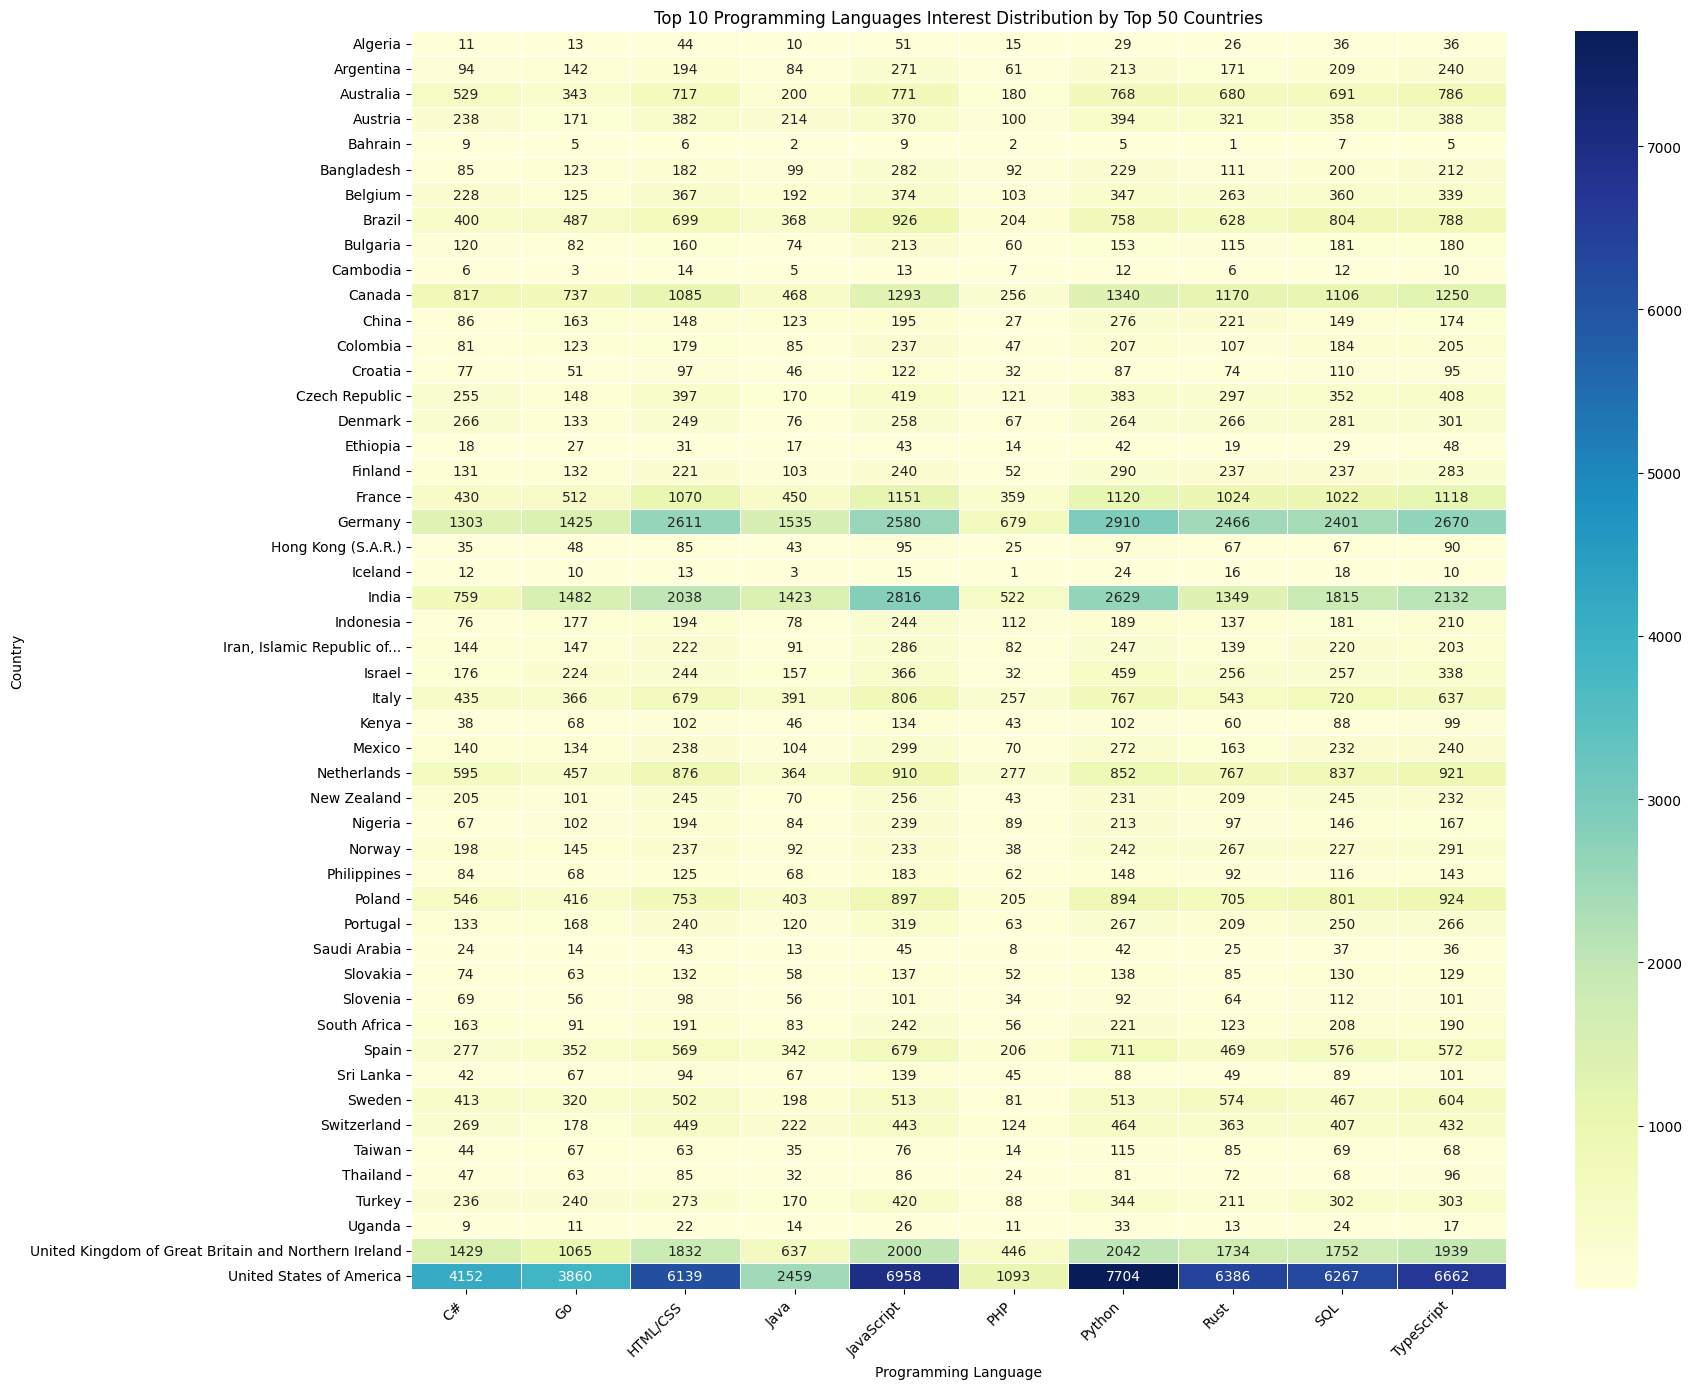

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Find the top 50 countries based on the number of entries
top_countries = language_counts_by_country_pd['Country'].value_counts().index[:50]
print("Top Countries:", top_countries)

# Find the top 10 languages for clarity
top_languages = language_counts_by_country_pd['Language'].value_counts().index[:10]

# Filter data to include only the top languages and top countries
filtered_data = language_counts_by_country_pd[
    language_counts_by_country_pd['Language'].isin(top_languages) &
    language_counts_by_country_pd['Country'].isin(top_countries)
]

# Pivot the data to get a matrix format for the heatmap
heatmap_data = filtered_data.pivot_table(index='Country', columns='Language', values='count', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(18, 14))  # Adjust size to fit all top 50 countries
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)
plt.title('Top 10 Programming Languages Interest Distribution by Top 50 Countries')
plt.xlabel('Programming Language')
plt.ylabel('Country')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [9]:
# Stop the Spark session
spark.stop()
